In [15]:
# Final EE vs ramp time (T_cut) for J in {2,1,0.5} — styled like previous figs

import numpy as np
import qutip as qt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pathlib import Path
from datetime import datetime
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

# ====== Matplotlib: presentation style (big labels, inward ticks) ======
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

# ---- helpers (same vibe as earlier figs) ----
def label_right_of_last(ax, x, y, text, *, dx_pt=8, fontsize=16):
    """
    曲線の最後の点 (x[-1], y[-1]) の『右側』に、同じ高さでラベルを置く。
    - dx_pt: 右方向オフセット（ポイント）
    """
    ax.annotate(
        text,
        xy=(x[-1], y[-1]),
        xytext=(dx_pt, 0), textcoords="offset points",
        ha="left", va="center",
        fontsize=fontsize,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.7, lw=0),
        path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        clip_on=False,  # 右端に少しはみ出しても切れないように
        zorder=5,
    )
    
def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True,
                   length=major_len, width=width)
    ax.tick_params(which="minor", length=minor_len, width=width)

def _screen_angle(ax, x, y, i):
    trans = ax.transData.transform
    i0, i1 = max(i-1, 0), min(i+1, len(x)-1)
    (x0, y0) = trans((x[i0], y[i0])); (x1, y1) = trans((x[i1], y[i1]))
    return np.degrees(np.arctan2(y1-y0, x1-x0))

# ====== Model / lattice ======
Lx, Ly, cut_pos = 4, 4, 2
N = Lx * Ly
delta = 1.0
T_total, nt = 10.0, 200
tlist = np.linspace(0.0, T_total, nt)
idx = lambda x, y: y * Lx + x

# Bonds
def nn_bonds_4x4():
    B = []
    for y in range(Ly):
        for x in range(Lx):
            if x + 1 < Lx: B.append((idx(x,y), idx(x+1,y)))
            if y + 1 < Ly: B.append((idx(x,y), idx(x,y+1)))
    return [tuple(sorted(b)) for b in B]

bonds_all = nn_bonds_4x4()
cut_list   = [(idx(1,y), idx(2,y)) for y in range(Ly)]
keep_bonds = [b for b in bonds_all if b not in cut_list]

# Operators & unit Hamiltonians (J=1)
sx, sy, sz = [0.5*M for M in (qt.sigmax(), qt.sigmay(), qt.sigmaz())]
I2 = qt.qeye(2)
def op_at(i, op): return qt.tensor([op if k==i else I2 for k in range(N)])
S = [(op_at(i,sx), op_at(i,sy), op_at(i,sz)) for i in range(N)]
def H_bond_unit(i,j, delta=delta):
    Sxi,Syi,Szi = S[i]; Sxj,Syj,Szj = S[j]
    return (Sxi*Sxj + Syi*Syj + delta*Szi*Szj)

H_keep_unit  = sum(H_bond_unit(i,j) for (i,j) in keep_bonds)
Hm_unit_list = [H_bond_unit(i,j) for (i,j) in cut_list]
H_all_unit   = H_keep_unit + sum(Hm_unit_list)

# Ramp profile
def c_ramp(t, T_cut):
    if T_cut <= 0.0: return 1.0 if t <= 0.0 else 0.0
    if t <= 0.0:     return 1.0
    if t >= T_cut:   return 0.0
    return 1.0 - t/T_cut

# Time-dependent Hamiltonian for (T_cut, J)
def make_H_time(T_cut: float, J: float):
    H_t = [J * H_keep_unit]
    def coeff(t, args=None): return J * c_ramp(t, T_cut)
    for Hm in Hm_unit_list:
        H_t.append([Hm, coeff])
    return H_t

# Initial state: ground state of H_all(J=1)
_, psi_ground = H_all_unit.groundstate(sparse=True)

# Entanglement Entropy on left half
left_sites = [idx(x,y) for y in range(Ly) for x in range(cut_pos)]
def EE_op(t, state, args=None):
    rhoL = qt.ptrace(state, left_sites)
    return float(qt.entropy_vn(rhoL, base=2))  # bits

solver_opts = dict(store_states=False, progress_bar=None,
                   rtol=1e-6, atol=1e-8, nsteps=20000)

def run_EE_final(T_cut: float, J: float, psi0):
    H_t = make_H_time(T_cut, J)
    sol = qt.sesolve(H_t, psi0, tlist, e_ops=[EE_op], options=solver_opts)
    return np.array(sol.expect[0])[-1]

def run_EE_curve(T_cut: float, J: float, psi0):
    H_t = make_H_time(T_cut, J)
    sol = qt.sesolve(H_t, psi0, tlist, e_ops=[EE_op], options=solver_opts)
    return np.array(sol.expect[0])

# ====== Sweep settings ======
T_ramps = np.linspace(0.0, 10.0, 21)  # 0.0 ... 10.0 (step 0.5)
J = 1.0
final_EE = np.array([run_EE_final(T_cut, J, psi_ground) for T_cut in T_ramps], dtype=float)

saved: ../data/finalEE_J1_square.csv


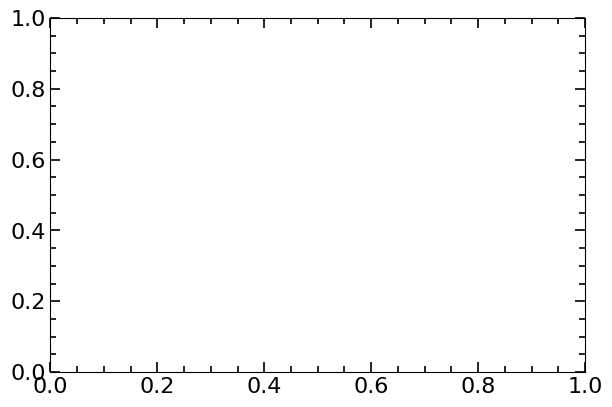

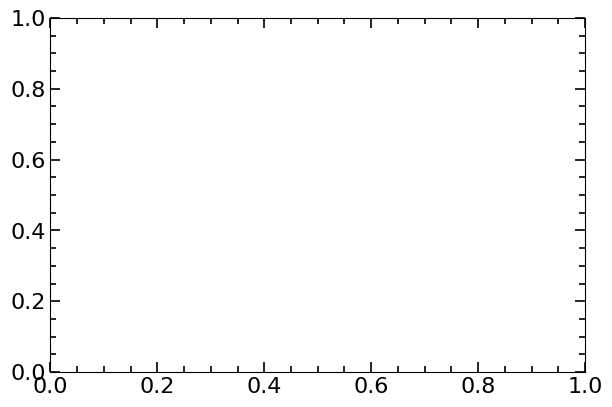

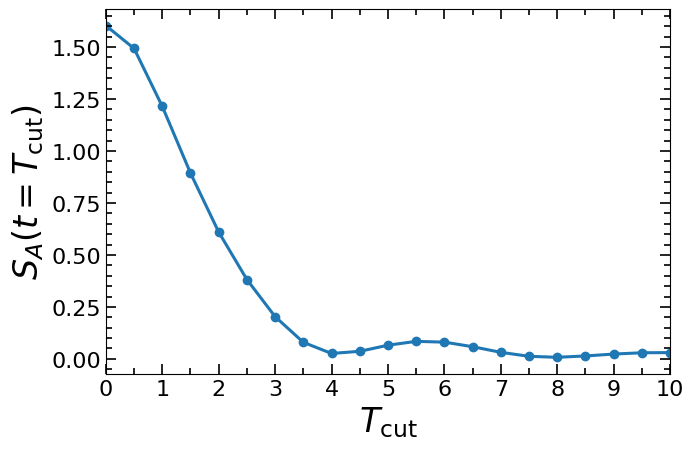

In [17]:
fig1, ax1 = plt.subplots(figsize=(6.9, 4.6))
inward_ticks(ax1)

x = T_ramps; y = final_EE 

# （念のため）x, y を 1D の float 配列に
x = np.asarray(x, dtype=float).ravel()
y = np.asarray(y, dtype=float).ravel()

# 長さチェック
assert x.shape == y.shape, f"length mismatch: x={x.shape}, y={y.shape}"

# 保存先
OUTDIR = Path("../data"); OUTDIR.mkdir(parents=True, exist_ok=True)
csv_path = OUTDIR / "finalEE_J1_square.csv"     # ファイル名はお好みで

# 2列 [T_cut, S_A] で保存
np.savetxt(csv_path, np.column_stack([x, y]),
           delimiter=",", header="T_cut,S_A", comments="", fmt="%.8g")

print(f"saved: {csv_path}")

ln, = ax1.plot(
    x, y,
    markersize=6.0,          # 裏ほど大→表ほど小
    marker='o',
    zorder=1)              # 表ほど手前),           

ax1.set_xlim(0.0, 10.0)
ax1.set_xlabel(r"$T_{\mathrm{cut}}$", fontsize=24)
ax1.set_ylabel(r"$S_A(t = T_{\mathrm{cut}})$", fontsize=24)
ax1.set_title("")
ax1.xaxis.set_major_locator(MultipleLocator(1.0))
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
x = np.asarray(x, dtype=float)
y = np.asarray(y, dtype=float)
fig1.tight_layout()

plt.show() # ここで一度だけ表示 plt.close('all') # ← これで自動描画の“もう一回”を防ぐ